In [41]:
from mave_calibration.initializations import constrained_gmm_init, gmm_init
from mave_calibration.skew_normal import density_utils
from mave_calibration.evidence_thresholds import get_tavtigian_constant

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mave_calibration import em_opt
from tqdm.autonotebook import tqdm
import joblib
import json

In [2]:
def plot(X, S, current_weights, current_params):
    N_samples = S.shape[1]
    fig,ax = plt.subplots(N_samples,1,figsize=(10,10),sharex=True,sharey=True)
    for sample_num in range(N_samples):
        sns.histplot(X[S[:,sample_num]], ax=ax[sample_num] ,stat='density')
    layer_distributions(X, S, current_weights, current_params, ax, label='estimated')
    return fig,ax

def layer_distributions(X, S, weights_, params_, ax,label="",linestyle='-'):
    cmap = sns.color_palette("tab10", S.shape[1] + 1)
    N_samples = S.shape[1]
    rng = np.arange(X.min(), X.max(), .01)
    for sample_num in range(N_samples):
        component_joint_pdfs = density_utils.joint_densities(rng, params_, weights_[sample_num])
        for component_num in range(N_components):
            ax[sample_num].plot(rng, component_joint_pdfs[component_num],
                label=f"Component {component_num} {label}",
                color=cmap[component_num],
                linestyle=linestyle)
            mixture_pdf = component_joint_pdfs.sum(axis=0)
        ax[sample_num].plot(rng, mixture_pdf, label=f"Mixture {label}",color=cmap[-1],linestyle=linestyle)

load data

In [61]:
dataset_id = "urn_mavedb_00000068-a-1"
config_name = "gnomad_config"
data = joblib.load(f"/mnt/d/mave_calibration/data/{dataset_id}/observations.pkl")
with open(f"/mnt/d/mave_calibration/data/{dataset_id}/{config_name}.json") as f:
    config = json.load(f)

sample data

In [63]:
sample_names = list(config['sample_definitions'].keys())
X = np.zeros((0,))
S = np.zeros((0,len(sample_names)),dtype=bool)
for i,sample_name in enumerate(sample_names):
    X = np.concatenate((X,data[sample_name]))
    si = np.zeros((data[sample_name].shape[0],len(sample_names)),dtype=bool)
    si[:,i] = True
    S = np.concatenate((S,si))
if config['invert_scores']:
    X = -X

initialize model

In [64]:
N_RESTARTS = 5
MAX_N_ITERS = 1000
CONSTRAINED = True
SKEW_INITS = []

N_samples = S.shape[1]
N_components = 2

best_fit = []
best_likelihood = -np.inf
for repetition in range(N_RESTARTS):
    if CONSTRAINED:
        initial_params = constrained_gmm_init(X,n_inits=1,n_components=N_components)
    else:
        initial_params = gmm_init(X,n_inits=1,n_components=N_components)
    if len(SKEW_INITS) > 0:
        initial_params[0][0] = abs(initial_params[0][0]) * SKEW_INITS[0]
        initial_params[1][0] = abs(initial_params[1][0]) * SKEW_INITS[1]
    W = np.ones((N_samples, N_components)) / N_components
    W = em_opt.utils.get_sample_weights(X, S, initial_params, W)
    likelihoods = np.array([em_opt.utils.get_likelihood(X, S, initial_params, W)/len(S),])
    xlims = (X.min(), X.max())
    if CONSTRAINED:
        updated_component_params, updated_weights = em_opt.utils.constrained_em_iteration(X, S, initial_params, W, xlims)
    else:
        updated_component_params, updated_weights = em_opt.utils.em_iteration(X, S, initial_params, W)
    likelihoods = np.array([*likelihoods,em_opt.utils.get_likelihood(X, S, updated_component_params, updated_weights)/len(S)])
    pbar = tqdm(total=MAX_N_ITERS)
    for i in range(MAX_N_ITERS):
        if CONSTRAINED:
            updated_component_params, updated_weights = em_opt.utils.constrained_em_iteration(X, S, updated_component_params, updated_weights, xlims)
        else:
            updated_component_params, updated_weights = em_opt.utils.em_iteration(X, S, updated_component_params, updated_weights)
        likelihoods = np.array([*likelihoods,em_opt.utils.get_likelihood(X, S, updated_component_params, updated_weights)/len(S)])
        pbar.set_postfix({"likelihood":f"{likelihoods[-1]:.6f}"})
        pbar.update(1)
        if i > 51 and (np.abs(likelihoods[-50:] - likelihoods[-51:-1]) < 1e-10).all():
            break
    pbar.close()
    if likelihoods[-1] > best_likelihood:
        best_fit = (updated_weights,updated_component_params)
        best_likelihood = likelihoods[-1]


 14%|█▍        | 141/1000 [00:03<00:19, 44.63it/s, likelihood=-0.533020]


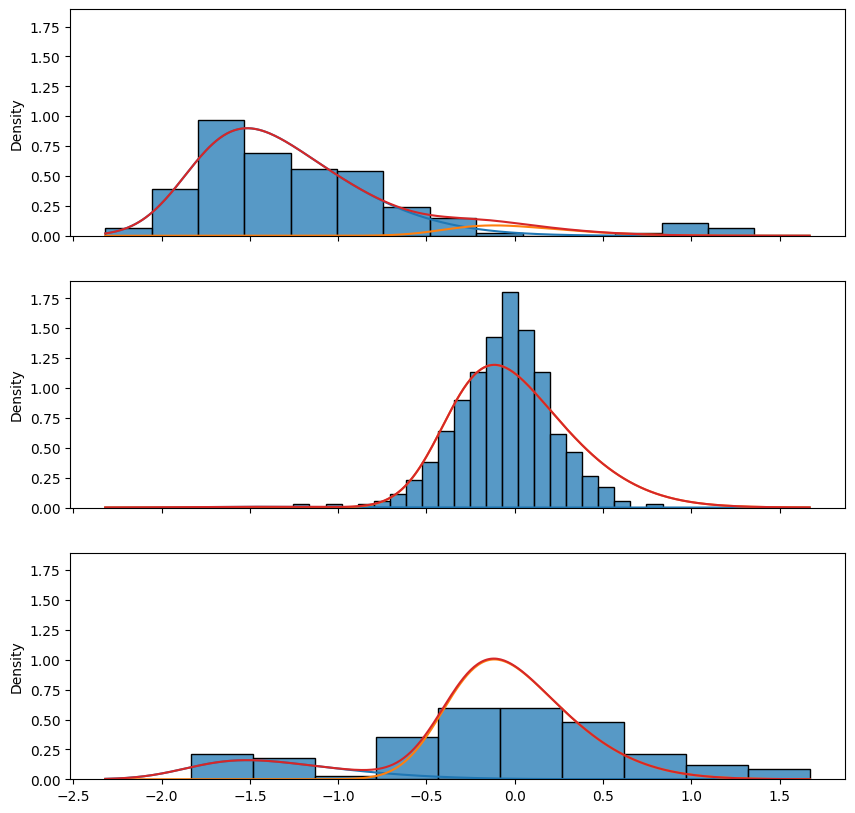

In [65]:
fig, ax = plot(X,S,updated_weights,updated_component_params)

In [66]:
updated_weights

array([[0.92800177, 0.07199823],
       [0.00632309, 0.99367691],
       [0.16504525, 0.83495475]])

Text(0, 0.5, 'Negative Log Likelihood')

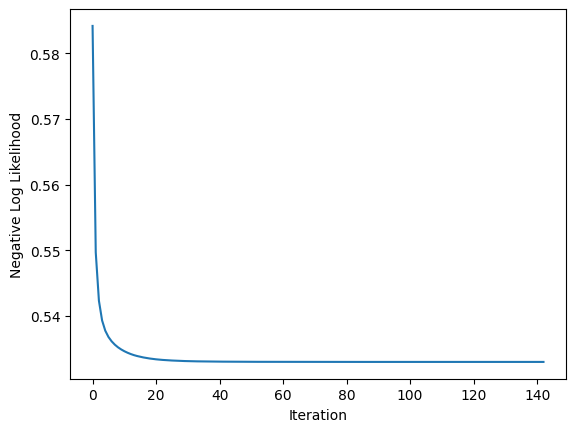

In [67]:
plt.plot(np.array(likelihoods) * -1)
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')

In [49]:
def prior_from_weights(W):
    prior = ((W[2,0] - W[1,0]) / (W[0,0] - W[1,0])).item()
    return np.clip(prior,1e-10,1 - 1e-10)

In [50]:
def P2LR(p,alpha):
    p = np.clip(p,1e-10,1-1e-10)
    return p / (1 - p) * (1 - alpha) / alpha
    # return np.log(p) - np.log(1 - p) + np.log(1-alpha) - np.log(alpha)

def LR2P(lr,alpha):
    return 1 / (1 + np.exp(-1 * ((np.log(lr) + np.log(alpha) - np.log(1 - alpha)))))

In [55]:
def layer_evidence(ax,prior):
    axlen = ax.get_xlim()[1] - ax.get_xlim()[0]
    xdim = ax.get_xlim()[0] + axlen * .05
    C= get_tavtigian_constant(prior)
    for i,ls,strength in zip(1 / (2**np.arange(4)),
                    ['-','--','-.',':'],
                    ['VSt','St',"Mo",'Su']):
        ax.axhline(C**i, color='r', linestyle=ls)
        t = ax.text(xdim, C**i, f"P {strength}",fontsize=8)
        t.set_bbox(dict(facecolor='white', alpha=.8, edgecolor='white'))
        t2 = ax.text(xdim,C**-i,f"B {strength}",fontsize=8)
        t2.set_bbox(dict(facecolor='white', alpha=.8, edgecolor='white'))
        ax.axhline(C**(-1 * i), color='b', linestyle=ls)

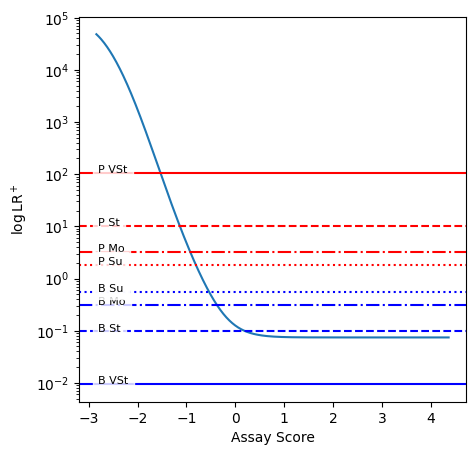

In [56]:
rng = np.arange(X.min(), X.max(), .01)
prior = prior_from_weights(updated_weights)
f_P = density_utils.joint_densities(rng, updated_component_params, updated_weights[0]).sum(0)
f_B = density_utils.joint_densities(rng, updated_component_params, updated_weights[1]).sum(0)
# posterior = (prior * f_P) / (prior * f_P + (1 - prior) * f_B)

fig, ax = plt.subplots(1,1,figsize=(5,5),sharex=True)
ax.plot(rng, f_P / f_B)
layer_evidence(ax,prior)
ax.set_yscale('log')
ax.set_xlabel("Assay Score")
_ = ax.set_ylabel(r"$\log \text{LR}^+ $")
